In [81]:
import pandas as pd
import numpy as np
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

## Задание

##### Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

##### Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [6]:
df = pd.read_csv('C:/Users/M&M/Python/Задание_АВ-тест.csv', sep=';')

In [ ]:
# Ниже применяю первичные методы для анализа датафрейма.

In [7]:
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [8]:
df.shape

(404770, 3)

In [11]:
df.nunique()
# Проверяем все ли user_id уникальные - сравниваю общим кол-вом строк в df.shape. И сколько тестовых групп. 

user_id      404770
revenue        1477
testgroup         2
dtype: int64

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [14]:
# Вываодим базовые статистические показатели и общую сумма revenue по пользователям, которые совершили покупку в каждой группе.
df.query('revenue != 0').groupby('testgroup').agg({'revenue': ['sum', 'describe']})

revenue                                                             \
               sum describe                                                     
           revenue    count         mean          std     min     25%     50%   
testgroup                                                                       
a          5136189   1928.0  2663.998444  9049.039763   200.0   257.0   311.0   
b          5421603   1805.0  3003.658172   572.619709  2000.0  2513.0  3022.0   

                            
                            
              75%      max  
testgroup                   
a           361.0  37433.0  
b          3478.0   4000.0

In [ ]:
# В таблице выше отмечаю, что:
# - в тестовой группе обзая сумма продаж , среднее и медианные значения выше чем в контрольной группе.
# - отмечаю, что очень большое стандартное отклонение в контрольной группе. 
# - Среднее в тестовой группе очень сильно отличается от медианы. 
# - Макисмальное значение в контрльной группе почти в 10 раз больше чем в контрольной.
# Данные выводы нужно проверить.

<Axes: ylabel='revenue'>

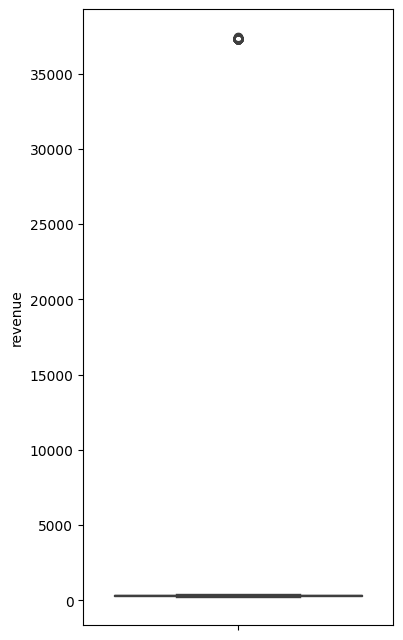

In [25]:
plt.figure(figsize=(4, 8))
sns.boxplot(df[(df['testgroup'] == 'a') & (df['revenue'] > 0)].revenue)
# На чарте видны выбросы revenue в контрольной группе, которые сильно искажают результаты.

In [45]:
control_extreme = df[(df['testgroup'] == 'a') & (df['revenue'] > 35000)]
print(f'Кол-во клинетов с revenue > 35 000 = {int(control_extreme.user_id.nunique())}')
print(f'Сумма revenue по этим клиентам {float(control_extreme.revenue.sum())}')
print(f'Сумма revenue по этим клиентам составляет {round(control_extreme.revenue.sum() / df[df['testgroup']=='a'].revenue.sum()*100,2)}% от общей суммы контрольной группы.')

Кол-во клинетов с revenue > 35 000 = 123
Сумма revenue по этим клиентам 4590252.0
Сумма revenue по этим клиентам составляет 89.37% от общей суммы контрольной группы.


###### Необходимо проверить репрезентативность разделения на группы до проведения теста.
######
###### Для продолжения анализа из контрольной группы будут исключены найденые 123 пользователя с revenue > 35 000.

In [48]:
df_new = df.query('revenue < 35000')

In [51]:
# Проверка сколько пользователей исключилось.
df_new.shape[0] - df.shape[0]

-123

In [52]:
# Повторяю проверку статитических показателей после чистки датафрейма.
df_new.query('revenue != 0').groupby('testgroup').agg({'revenue': ['sum', 'describe']})

revenue                                                            \
               sum describe                                                    
           revenue    count         mean         std     min     25%     50%   
testgroup                                                                      
a           545937   1805.0   302.458172   57.914246   200.0   254.0   305.0   
b          5421603   1805.0  3003.658172  572.619709  2000.0  2513.0  3022.0   

                           
                           
              75%     max  
testgroup                  
a           352.0   400.0  
b          3478.0  4000.0

In [53]:
# Видим, что в контрольной группе значания стали более логичными. Также выровнялось кол-во пользователей между группами.

In [77]:
# Проверим ARPU (Average Revenue Per User) для каждой группы. 
arpu_a = int(df_new[df_new['testgroup']=='a'].revenue.sum() / df_new[df_new['testgroup']=='a'].user_id.count())
arpu_b = int(df_new[df_new['testgroup']=='b'].revenue.sum() / df_new[df_new['testgroup']=='b'].user_id.count())
arpu_diff = round((arpu_b/arpu_a)*100-100,2)
print(f'ARPU контрольной группы {arpu_a}')
print(f'ARPU тестовой группы {arpu_b}')
print('')
print(f'>>Вывод: \033[1m ARPU в тестовой группе "b" больше на {arpu_diff}% чем в контрольной группе "a".')

ARPU контрольной группы 2
ARPU тестовой группы 26

>>Вывод:  ARPU в тестовой группе "b" больше на 1200.0% чем в контрольной группе "a".


In [62]:
total_revenue_a = df_new[df_new['testgroup']=='a'].revenue.sum()
total_revenue_b = df_new[df_new['testgroup']=='b'].revenue.sum()
import locale 
locale.setlocale(locale.LC_ALL, '')
print(f'Revenu контрольной группы {total_revenue_a:,}')
print(f'Revenu тестовой группы {locale.format_string("%d", total_revenue_b, grouping=True)}')
print(f'>>Вывод: Разница в 10 раз.')

Revenu контрльной группы 545,937
Revenu тестовой группы 5 421 603
>>Вывод: Разница в 10 раз.


In [78]:
# Проверим конверсию.
conversion_a = round(df_new[df_new['testgroup']=='a'].query('revenue != 0').user_id.count() / df_new[df_new['testgroup']=='a'].user_id.count() *100, 3)
conversion_b = round(df_new[df_new['testgroup']=='b'].query('revenue != 0').user_id.count() / df_new[df_new['testgroup']=='b'].user_id.count() *100, 3)

print(f'Конверсия в контрольной группе = {conversion_a}%')
print(f'Конверсия в тестовой группе = {conversion_b}%')
print('')
print(f'>>Вывод: \033[1m Разница конверсии между группами {round(conversion_b-conversion_a,3)}%. Проверим стат значимость разницы конверсии.')

Конверсия в контрольной группе = 0.894%
Конверсия в тестовой группе = 0.891%

>>Вывод:  Разница конверсии между группами -0.003%.


In [88]:
conversion_aa = df_new[(df_new['testgroup'] == 'a') & (df_new['revenue'] != 0)].user_id.nunique()
conversion_bb = df_new[(df_new['testgroup'] == 'b') & (df_new['revenue'] != 0)].user_id.nunique()


users_a = df_new[df_new['testgroup'] == 'a'].user_id.nunique()
users_b = df_new[df_new['testgroup'] == 'b'].user_id.nunique()

conversion = np.array([conversion_aa, conversion_bb])
users = np.array([users_a, users_b])

z_stat, p_value = sm.stats.proportions_ztest(conversion, users)

print(f'Z-stat = {z_stat}')
print(f'P-value = {p_value}')

Z-stat = 0.1024661880905615
P-value = 0.9183866495500822


#### Интерпритация результата Z-теста:
##### Z-статистика близка к 0, что подтверждает минимальную разницу между группами.
##### P-Value = 0.91 - значительно превышает порог статистической значимости эксперимента p < 0,05. Поэтому результат изменение в группе "b" можно считать статистически незначимым. Ухуджение конверсии скорее всего случайна.

##### Вывод: 
##### На основании этих данных можно сделать вывод, что изменение набора предложение не имеет статистической разницы. Поэтому применять изменение глобально не иммет смысла.